# **Scraping Covid19 articles on TheJournal.ie**

*   **Status:** DRAFT

*   **Data source:** scraping Covid19 related article titles from TheJournal.ie, their date of publication, and their engagement on social media.

*   **Objective:** the purpose of this project is to try and provide a data oriented overview of Covid19 related articles on TheJournal, one of the major online medias in Ireland.

# **Modules**

In [1]:
# global purpose modules
from datetime import date, datetime, timedelta
import random
import re
import time
import pandas as pd
import numpy as np

# scraping modules
from bs4 import BeautifulSoup
import urllib
import requests

# dataviz
from plotly import express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from matplotlib import style

# sentiment
from textblob import TextBlob, Word

# **Scraping**

In [8]:
# url level scraping function
def getPageContent(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    for s in soup.find_all("a"):
        if str(s.get('title')).startswith("Comment on"):
            articles.append(s.get('title').replace("Comment on ",""))
    for s in soup.find_all("span", class_="published-at"):
        published.append(s.text.strip())
    for s in soup.find_all("span", class_="interactions"):
        likes.append(s.text.split(" ")[0].replace("\n",""))
    for s in soup.find_all("span", class_="interactions"):
        views.append(s.text.split(" ")[3])

# creating lists to store scraped data
articles, published, likes, views = [], [], [], []

# looping through the urls and calling the scraping functions
def getSiteContent():
    urls = [f"https://www.thejournal.ie/covid19-facts/news/page/{i}/" for i in range(1,20)]
    for u in urls:
        getPageContent(u)
    df = {"date":published,
          "views":views,
          "likes":likes,
          "article":articles
          }
    df = pd.DataFrame(df)
    return df

# making sure it worked
df = getSiteContent()

# saving a copy of the df
data = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     596 non-null    object
 1   views    596 non-null    object
 2   likes    596 non-null    object
 3   article  596 non-null    object
dtypes: object(4)
memory usage: 18.8+ KB


# **Data cleaning and functions**

In [9]:
# function to clean the date serie
def getCleanDates(serie):
    if "update" in serie.lower():
        if not re.search("Mon|Tue|Wed|Thu|Fri|Sat|Sun",serie):
            return serie.replace("Updated","").strip().split(",")[0]
    elif re.search("Mon|Tue|Wed|Thu|Fri|Sat|Sun",serie):
        cleanedText = serie.replace("Updated\n","").strip().split(" ")[0]
        today = date.today()
        for i in range(7):
            day = today - timedelta(days=i)
            if day.strftime("%A")[:3] == cleanedText:
                return day
    else:
        return serie.split(",")[0]

# applying the function, then converting to datetime format
df["date"] = df["date"].apply(getCleanDates)
df["date"] = pd.to_datetime(df["date"])

# converting Likes and Views to numeric format
df["views"] = df["views"].apply(lambda x: x.replace(",","")).astype(int)
df["likes"] = df["likes"].apply(lambda x: x.replace(",","")).astype(int)

# adding in a function that tags articles depending on their topic
def getTags(serie):
    s = serie.lower()
    if "vaccin" in s:
        return "Vaccine"
    elif "new case" in s:
        return "Daily press announcement"
    elif "lockdown" in s:
        return "Lockdown"
    elif re.search("flight|airport|travel|passenger",s):
        return "Travel"
    elif "quarantine" in s:
        return "Hotel quarantine"
    elif re.search("doherty|waters|protest|conspiracy|dolores cahill",s):
        return "Conspiracy debunking"
    else:
        return "General news"

df["tag"] = df["article"].apply(getTags)

# no need for tokenization / lemmatization, jumping into sentiment eval directly
df["sentiment_score"] = df["article"].apply(lambda x: TextBlob(x).sentiment.polarity)

# also creating categorical bins for sentiment
def getSentiment(serie):
    if serie > 0.15:
        return "Positive"
    elif serie < 0:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_tag"] = df["sentiment_score"].apply(getSentiment)

# showing the latest entries
df = df.sort_values("date", ascending=False)
df.head(5)

,date,views,likes,article,tag,sentiment_score,sentiment_tag
0,2021-06-03,35,24050,Hiqa advises NPHET to extend presumptive Covid...,General news,0.000000,Neutral
1,2021-06-03,41,19485,Emergency Covid-19 powers extended after narro...,General news,-0.200000,Negative
2,2021-06-02,69,48717,Coronavirus: 407 new cases confirmed in Ireland,Daily press announcement,0.268182,Positive
3,2021-06-02,40,32262,Ireland to receive extra Pfizer vaccines after...,Vaccine,0.000000,Neutral
5,2021-06-01,63,43800,Pharmacists to start administering Covid-19 va...,Vaccine,0.000000,Neutral


In [10]:
# creating a function that groups / aggregates data, in SQL fashion
def getGroupBy(dataframe,serie,aggregates,ordered):
    grouped = dataframe.copy()
    grouped["volume"] = grouped[serie].groupby(grouped[serie]).transform("count")
    grouped = grouped.groupby(serie, as_index=False).agg(aggregates)
    grouped = grouped.sort_values(ordered, ascending=True)
    return grouped

# for time series specifically, this function will make plotting easier
def getTimeIndex(dataframe,serie):
    dataframe = dataframe.set_index(pd.DatetimeIndex(dataframe[serie].values))
    dataframe.drop(columns=[serie], inplace=True)
    return dataframe

# grouping by
data = getGroupBy(df,
                  "date",
                  {"volume":"max",
                   "views":"sum",
                   "likes":"sum"
                  },
                  "date")

# datetime index
data = getTimeIndex(data,"date")

# result
data.head(5)

,volume,views,likes
2020-02-25,1.0,27,101041
2020-02-27,1.0,10,19735
2020-02-28,1.0,32,82596
2020-02-29,1.0,11,24495
2020-03-02,3.0,113,226721


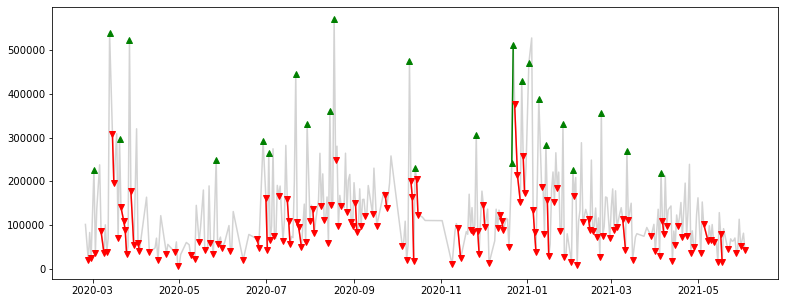

In [11]:
# function to calculate increases / decreases relatives to the mean and std
def getIncDec(dataframe,serie):
    data = dataframe.copy()
    data["previous"] = data[serie].shift(1)
    data["up"] = data.apply(lambda x: x[serie] - x["previous"] if x[serie] > x["previous"] else np.nan, axis=1)
    data["down"] = data.apply(lambda x: x[serie] - x["previous"] if x[serie] < x["previous"] else np.nan, axis=1)
    AVG_up = data["up"].mean() + data["up"].std()
    AVG_down = data["down"].mean() + data["down"].std()
    data["increase"] = data.apply(lambda x: x[serie] if x["up"] > AVG_up else np.nan, axis=1)
    data["decrease"] = data.apply(lambda x: x[serie] if x["down"] < AVG_down else np.nan, axis=1)
    data = data.filter([serie,"increase","decrease"])
    return data

test = getIncDec(data,"likes")

plt.figure(figsize=(13,5))
plt.plot(test.index,test["likes"], color="lightgrey")
plt.plot(test.index,test["increase"], marker="^", color="green")
plt.plot(test.index,test["decrease"], marker="v", color="red")
plt.show()

In [12]:
# finally, using get_dummies to obtain a Pandas equivalent to pivot tables in Excel
def getDummies(dataframe,serie):
    dummies = pd.get_dummies(dataframe, prefix="Total", columns=[serie])
    return dummies

# calling the function
data = df.filter(["date","sentiment_tag"])
data = getDummies(data,"sentiment_tag")

# grouping by
data = getGroupBy(data,
                  "date",
                  {"Total_Negative":"sum",
                   "Total_Neutral":"sum",
                   "Total_Positive":"sum"},
                  "date"
                  )
# datetime index
data = getTimeIndex(data,"date")

# result
data.head(5)

,Total_Negative,Total_Neutral,Total_Positive
2020-02-25,0,1,0
2020-02-27,0,1,0
2020-02-28,1,0,0
2020-02-29,0,0,1
2020-03-02,0,3,0


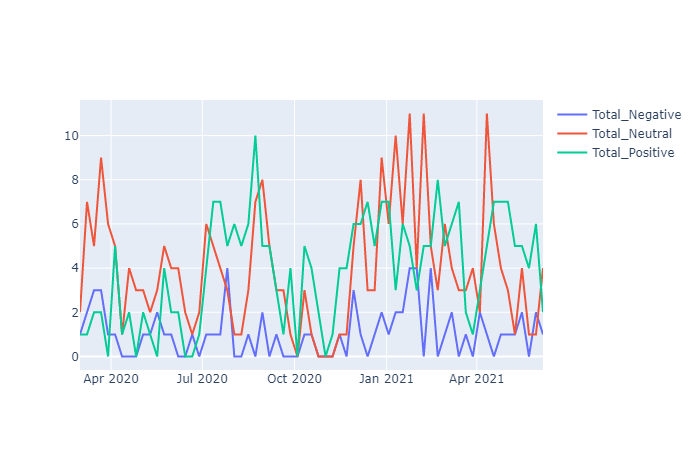

In [15]:
weekly = data.resample("W").sum()
fig = go.Figure()
for c in weekly.columns.values:
    fig.add_trace(go.Scatter(x=weekly.index, 
                             y=weekly[c],
                             mode="lines",
                             name=c)
  )
fig.show("png")

# **Data visualization**